## Import Data ##

In [67]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', None)

df_action=pd.read_excel('actions.xlsx')
df_action.drop(columns=['action_channel'],inplace=True)

df_clients=pd.read_excel('clients.xlsx')
df_transaction=pd.read_excel('transactions.xlsx')
df_transaction = pd.get_dummies(df_transaction, columns=['product_category'])
df_transaction.drop(columns=['product_subcategory',	'product_style'],inplace=True)

## Preparing Data ##

In [68]:
clients_in_action_not_in_transaction = list( set(df_transaction['client_id'])-set(df_action['client_id']) )
df_client_no_event = df_clients[df_clients['client_id'].isin(clients_in_action_not_in_transaction)]
df_no_event = pd.merge(df_client_no_event, df_transaction, on='client_id')
df_no_event=df_no_event['client_id']
#client_premium_status	client_is_phone_contactable	client_is_email_contactable	client_is_instant_messaging_contactable	client_is_contactable
df_no_event = df_no_event.to_frame()
df_no_event = df_no_event.reindex(columns=df_action.columns, fill_value='No event')


df_no_event['client_is_present']=0
df_no_event['client_is_invited']=0
df_no_event = pd.merge(df_no_event, df_transaction, on='client_id')
df_no_event

end_dates=df_action['action_end_date'].unique().tolist()

df_no_event['First Transaction Date_'] = df_no_event.groupby('client_id')['transaction_date'].transform('min')
df_no_event['Last Transaction Date_'] = df_no_event.groupby('client_id')['transaction_date'].transform('max')
df_no_event=df_no_event[~(df_no_event['First Transaction Date_'] == df_no_event['Last Transaction Date_'])]

df_no_event['action_end_date'] = df_no_event.apply(
    lambda row: next((date for date in end_dates if row['First Transaction Date_'] <= date <= row['Last Transaction Date_']), None),
    axis=1
)



In [62]:
df_merged = pd.merge(df_action, df_transaction, on='client_id')


    
# Update df_merged with filled no_event_rows

df_merged = pd.concat([df_merged, df_no_event], ignore_index=True)



product_category_columns = [col for col in df_transaction.columns if col.startswith('product_category')]




df_merged['Pre']= df_merged['action_end_date'] >= df_merged['transaction_date']
print(df_merged.shape)

# One-hot encode the 'product_category' column

#Add Product Category 
df_post=df_merged[(~df_merged['Pre'] )].groupby(['action_id', 'client_id']).agg({'product_quantity': 'sum', 'transaction_date': 'max','gross_amount_euro': 'sum','client_is_present': 'median'}).rename(columns={'product_quantity': 'Total Quantity', 'transaction_date': 'Last Transaction Date', 'gross_amount_euro': 'Total Gross Amount'})


# Add the sum to the groupby
df_pre = df_merged[df_merged['Pre']].groupby(['action_id', 'client_id']).agg({
    'product_quantity': 'sum',
    'transaction_date': 'min',
    'gross_amount_euro': 'sum',
    **{col: 'sum' for col in product_category_columns}
}).rename(columns={
    'product_quantity': 'Total Quantity pre',
    'transaction_date': 'First Transaction Date',
    'gross_amount_euro': 'Total Gross Amount pre'
})


df_combined = pd.merge(df_post, df_pre, on=['action_id', 'client_id'], how='inner')


df_merged.drop(columns=product_category_columns, inplace=True)

df_merged = pd.merge(df_merged[['action_id', 'client_id','action_end_date']], df_combined, on=['action_id', 'client_id'], how='inner')



#df_merged.drop(columns=['transaction_id', 'transaction_date', 'product_quantity', 'gross_amount_euro'], inplace=True)
df_merged.drop_duplicates(subset=['action_id', 'client_id'], keep='first', inplace=True)
print(df_merged.shape)
df_merged['Months_since_last_transaction'] = (df_merged['Last Transaction Date'] - df_merged['action_end_date'] ) / pd.Timedelta(days=30)
df_merged['Months_since_first_transaction'] = (df_merged['action_end_date'] - df_merged['First Transaction Date'] ) / pd.Timedelta(days=30)

df_merged['Mean Total pre'] = df_merged['Total Gross Amount pre']/df_merged['Months_since_first_transaction']
df_merged['Mean Total post'] = df_merged['Total Gross Amount']/df_merged['Months_since_last_transaction']
df_merged=df_merged.dropna()
df_merged['upflift']=(df_merged['Mean Total post']-df_merged['Mean Total pre'])#/df_merged['Mean Total pre']
df_merged=df_merged.drop(columns=['action_id','Months_since_last_transaction','Mean Total post'	,'Total Quantity',	'Last Transaction Date','Total Gross Amount'])
#df_merged = pd.merge(df_merged, df_clients, on=[ 'client_id'], how='inner')
#df_merged=df_merged.drop(columns=[ 'client_id','client_country',	'client_gender'	,'client_nationality',	'client_city'])
df_merged = df_merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['upflift'])

df_merged.columns

(80392, 37)
(3234, 26)


Index(['client_id', 'action_end_date', 'client_is_present',
       'Total Quantity pre', 'First Transaction Date',
       'Total Gross Amount pre', 'product_category_Child',
       'product_category_HC', 'product_category_House',
       'product_category_Jewelry', 'product_category_Men Accessory',
       'product_category_Men Bags', 'product_category_Men Ready-to-Wear',
       'product_category_Men Shoes',
       'product_category_Men Small Leather Goods', 'product_category_Unknown',
       'product_category_Watches', 'product_category_Woman Shoes',
       'product_category_Women Accessory', 'product_category_Women Bags',
       'product_category_Women Ready-to-Wear',
       'product_category_Women Small Leather Goods',
       'Months_since_first_transaction', 'Mean Total pre', 'upflift'],
      dtype='object')

## Predict the Turnover ## 

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

df_merged.set_index('client_id', inplace=True)

# One-hot encode the categorical data
categorical_columns = df_merged.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df_merged, columns=categorical_columns)

# Identify datetime columns
datetime_columns = df_merged.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Extract the month from each datetime column
for col in datetime_columns:
    df_merged[f'{col}_month'] = df_merged[col].dt.month

    # Drop the original datetime columns
df_encoded.drop(columns=datetime_columns, inplace=True)

# Remove outliers from the 'upflift' column
Q1 = df_encoded['upflift'].quantile(0.25)
Q3 = df_encoded['upflift'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
df_encoded = df_encoded[(df_encoded['upflift'] >= lower_bound) & (df_encoded['upflift'] <= upper_bound)]

df_encoded['client_is_present'] = df_encoded['client_is_present'].astype(int)


In [60]:
# Define features and target variable
X = df_encoded.drop(columns=['upflift'])
y = df_encoded['upflift']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = XGBRegressor(colsample_bytree= 0.6, learning_rate= 0.01, max_depth= 9, n_estimators= 300, subsample= 0.8)
model.fit(X_train, y_train)

# Train a CatBoostRegressor model
catboost_model = CatBoostRegressor(colsample_bylevel= 1.0, depth= 10, iterations= 400, learning_rate= 0.05, subsample=0.6, random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Predict and evaluate the CatBoost model
y_pred_catboost = catboost_model.predict(X_test)
rmse_catboost = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
print(f'CatBoost Root Mean Squared Error: {rmse_catboost}')
# Predict and evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

CatBoost Root Mean Squared Error: 3127.6654629347986
Root Mean Squared Error: 3110.826957449283


In [83]:

X_test_client_not_present.sort_index()


,client_is_present,Total Quantity pre,Total Gross Amount pre,product_category_Child,product_category_HC,product_category_House,product_category_Jewelry,product_category_Men Accessory,product_category_Men Bags,product_category_Men Ready-to-Wear,product_category_Men Shoes,product_category_Men Small Leather Goods,product_category_Unknown,product_category_Watches,product_category_Woman Shoes,product_category_Women Accessory,product_category_Women Bags,product_category_Women Ready-to-Wear,product_category_Women Small Leather Goods,Months_since_first_transaction,Mean Total pre
client_id,,,,,,,,,,,,,,,,,,,,,
c00029531,1,1,546,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.233333,2340.000000
c00978232,1,6,30297,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,0,11.333333,2673.264706
c01126511,1,2,10935,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,3.800000,2877.631579
c01165820,1,8,6050,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,4.366667,1385.496183
c01177833,1,1,2132,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7.100000,300.281690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c98984715,1,1,6742,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.100000,6129.090909
c99277667,1,4,9372,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,21.533333,435.232198
c99436180,1,3,9930,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1.633333,6079.591837


## Predict the turnover for client who weren't if they were 

In [82]:
# Create a copy of the test data with client_is_present set to 0
X_test_client_not_present = X_test.copy()

X_test_client_not_present ['client_is_present'] = 1

# Predict the uplift for the modified test data
y_pred_client_not_present = model.predict(X_test_client_not_present )

# Compare the predicted uplift with the original predictions
comparison_df = pd.DataFrame({
    'Original Uplift': y_pred,
    'Uplift with Client Not Present': y_pred_client_not_present
})

# Display the comparison
print(comparison_df)

     Original Uplift  Uplift with Client Not Present
0       -1352.908203                    -1352.908203
1        1527.639404                     1158.659912
2         590.363953                      590.363953
3        2080.178711                     2211.396729
4        1125.813721                     1443.762085
..               ...                             ...
508      2947.437500                     2807.394775
509       818.578186                      799.286194
510       895.907776                      663.261292
511      -718.034668                     -927.037415
512       438.560730                      438.560730

[513 rows x 2 columns]


##  Take the biggest 10 difference in Turnover ##

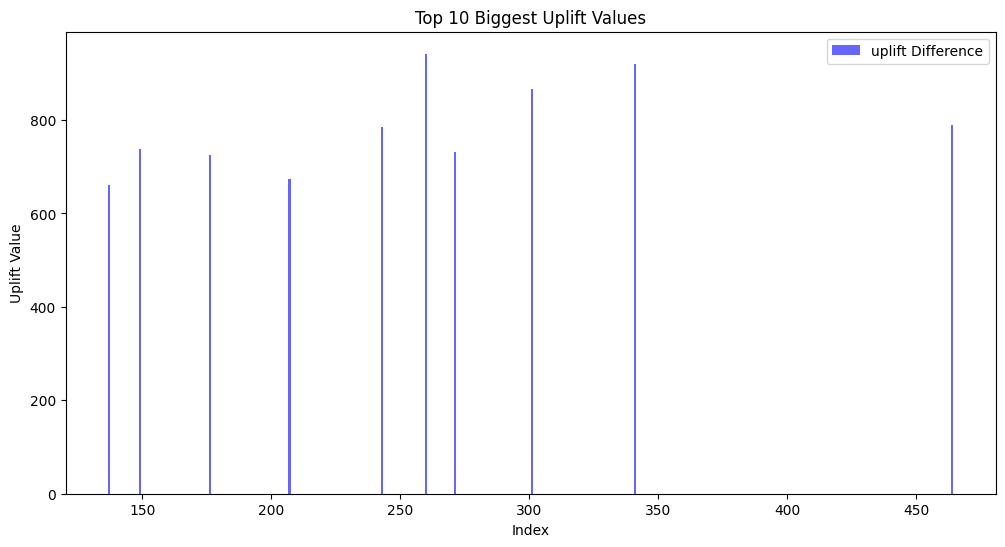

In [66]:
import pandas as pd

import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined as numpy arrays
# Convert them to a DataFrame for easier manipulation
results_df = pd.DataFrame({
    'uplift Difference' : abs(y_pred_client_not_present - y_pred)
})

# Sort the DataFrame by the Predicted Uplift in descending order
sorted_results_df = results_df.sort_values(by='uplift Difference', ascending=False)

# Select the top 10 biggest uplift values
top_10_uplift = sorted_results_df.head(10)

# Plot the top 10 biggest uplift values
plt.figure(figsize=(12, 6))
plt.bar(top_10_uplift.index, top_10_uplift['uplift Difference'], color='blue', alpha=0.6, label='uplift Difference')

plt.xlabel('Index')
plt.ylabel('Uplift Value')
plt.title('Top 10 Biggest Uplift Values')
plt.legend()
plt.show()

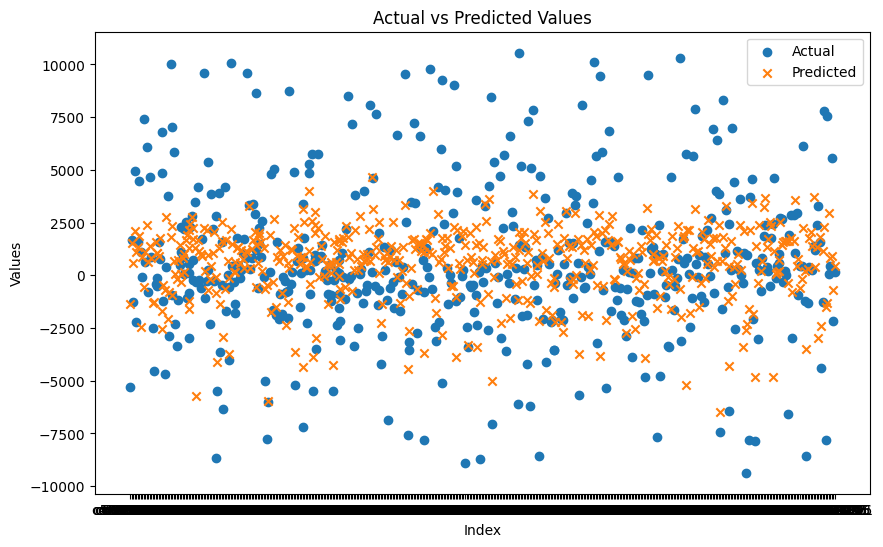

In [61]:
import matplotlib.pyplot as plt

# Plot y_test and y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test, label='Actual', marker='o')
plt.scatter(y_test.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Double ML to distinguish the general effect of inviting clients ##

In [27]:
import pandas as pd
import numpy as np

# Suppose df_encoded is your DataFrame

# Columns we will exclude from the covariates:
exclude_cols = [ 'client_is_present',   'upflift'         # The outcome
]

# Covariates = all columns except the ones above
X_cols = [col for col in df_encoded.columns if col not in exclude_cols]

# Treatment (D) and Outcome (Y)
D_col = 'client_is_present'
Y_col = 'upflift'


X = df_encoded[X_cols].values  # shape (n_samples, n_features)
D = df_encoded[D_col].values   # shape (n_samples, )
Y = df_encoded[Y_col].values   # shape (n_samples, )




In [32]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np

# Initialize models (you can choose other ML models, e.g., XGBoost)
# For outcome (continuous upflift), we use a regressor
outcome_model = RandomForestRegressor(n_estimators=100, random_state=42)

# For treatment (binary client_is_present), we use a classifier
treatment_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up cross-validation
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# To store treatment effect estimates from each fold
beta_estimates = []

for train_idx, test_idx in kf.split(X):
    # Split into train/test folds
    X_train, X_test = X[train_idx], X[test_idx]
    D_train, D_test = D[train_idx], D[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # 1. Fit outcome model (Y ~ X) on training fold
    outcome_model.fit(X_train, Y_train)
    # Predict Y on test fold
    Y_hat_test = outcome_model.predict(X_test)
    
    # 2. Fit treatment model (D ~ X) on training fold
    treatment_model.fit(X_train, D_train)
    # Predict probability of treatment=1 on test fold
    D_hat_test = treatment_model.predict_proba(X_test)[:, 1]
    
    # 3. Compute residuals
    u_test = Y_test - Y_hat_test  # residual for outcome
    v_test = D_test - D_hat_test  # residual for treatment
    
    # 4. Estimate treatment effect in this fold
    #    We'll do a simple slope = Cov(u, v) / Var(v)
    slope = np.cov(u_test, v_test, bias=True)[0, 1] / np.var(v_test)
    beta_estimates.append(slope)

# Average across folds
beta_hat = np.mean(beta_estimates)

print("Estimated Treatment Effect (Double ML):", beta_hat)


Estimated Treatment Effect (Double ML): -59.412717427011195


In [ ]:


from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
# Setup the estimator
dml_estimator = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, random_state=42),
     model_final=LinearRegression(),  
    discrete_treatment=True,  # Because client_is_present is binary
    random_state=42
)

dml_estimator.fit(Y, D, X=X, W=None)  # X is your covariates matrix (n x p)

# Get average treatment effect
ate = dml_estimator.effect(np.zeros_like(X))  # pass in a 'baseline' X
print("Estimated ATE:", ate.mean())




The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


Estimated ATE: 6388055.953438984
